# 특징점 추출을 통해 장소 카드 인식하기
먼저 특징점 추출을 위한 사전 준비를 합니다.

In [ ]:
import cv2
import numpy as np

from zumi.util.camera import Camera

WIDTH = 240
HEIGHT = 160
FRAMERATE = 10
camera = Camera(image_w=WIDTH, image_h=HEIGHT, framerate=FRAMERATE)

# 특징점 추출 알고리즘
orb = cv2.ORB_create()
# ORB를 위한 FLANN 설정값
FLANN_INDEX_LSH = 6
indexParams = dict(algorithm=FLANN_INDEX_LSH, table_number=6, key_size=12, multi_probe_level=1)
searchParams = dict(checks=20)
# 특징점 매칭 알고리즘
flann = cv2.FlannBasedMatcher(indexParams, searchParams)

특징점 추출 이후 사용될 함수를 정의합니다.
- `match` 함수는 특징점이 특정 카드와 일치하는 횟수를 반환하는 함수입니다. 한 특징점은 해당 점이 가지고 있는 여러 특징이 일치할 때 매칭되며, 제시된 카드는 같은 카드끼리 특징점이 가장 많이 매칭되어야 합니다.
- `matchDraw`는 `match` 함수의 결과를 시각화하여, 어떤 점이 어디에 매칭되었는지를 확인할 수 있습니다.

In [135]:
# 특징점 매칭 후 매칭된 횟수를 반환
def match(des1, des2):
    # 유력 특징점의 수
    cnt = 0
    # 두 이미지 간의 특징점 매칭
    try:
        matches = flann.knnMatch(des1, des2, k=2)
        for i, mn in enumerate(matches):
            # 1~2순위 특정 불가인 경우 예외 처리
            if len(mn) < 2: continue
            m, n = mn
            # 1순위 매칭 결과가 0.55 * 2순위 매칭 결과보다 작은 경우만 취급
            if m.distance < 0.75 * n.distance:
                cnt += 1
    # des2가 없을 경우
    except:
        pass
    finally:
        return cnt

# 디버깅용 이미지 매칭 표시
def matchDraw(img1, img2, kp1, kp2, des1, des2):
    try:
        # 두 이미지 간의 특징점 매칭
        matches = flann.knnMatch(des1, des2, k=2)
        matchesMask = [[0, 0] for i in range(len(matches))]
        for i, mn in enumerate(matches):
            # 1~2순위 특정 불가인 경우 예외 처리
            if len(mn) < 2: continue
            m, n = mn
            # 1순위 매칭 결과가 0.55 * 2순위 매칭 결과보다 작은 경우만 취급
            if m.distance < 0.75 * n.distance:
                matchesMask[i] = [1, 0]

        # 이미지 출력을 위한 설정
        draw_params = dict(
            matchColor=(0, 255, 0),
            singlePointColor=(255, 0, 0),
            matchesMask=matchesMask,
            flags=cv2.DrawMatchesFlags_DEFAULT
        )

        # 두 이미지, 특징점, 매칭된 점 간 엣지를 합친 이미지
        dst = cv2.drawMatchesKnn(img1, kp1, img2, kp2, matches, outImg=None, **draw_params)
        camera.show_image(dst)

    except:
        camera.show_image(img2)
        pass

매치에 사용될 장소 카드의 원본 이미지를 불러옵니다. 우리는 원본 이미지와 카메라에서 얻은 이미지의 특징점을 비교할 것입니다.

In [141]:
# Location 전처리
locations = []
location_kp_des = []
for num in range(4):
    location = cv2.imread("pattern_{num}.png".format(num=num), cv2.IMREAD_GRAYSCALE)
    locations.append(location)
    location_kp_des.append(orb.detectAndCompute(location, mask=None))

In [149]:
# 카메라 시작
camera.start_camera()

Starting PiCamera


In [ ]:
카메라에서 이미지를 캡쳐한 뒤, 흑백화 -> 이미지 대비 조정 이후 특징점을 추출합니다. 이렇게 전처리를 거치면, 불필요한 노이즈를 방지할 수 있습니다. 특징점 추출 이후에는 이미지낄 ㅣ 이미지 특징점 매칭 현황을 그리며, 특징점이 가장 많이 매칭된 이미지는 `(매칭된 점 수, 템플릿 인덱스)` 순으로 출력됩니다.

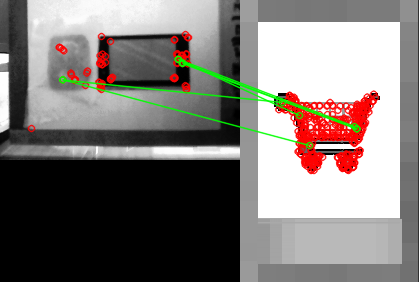

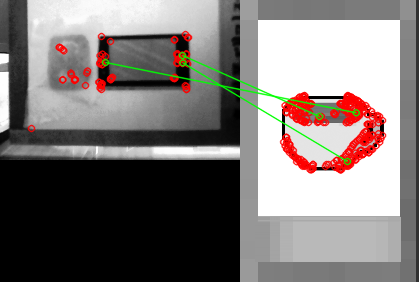

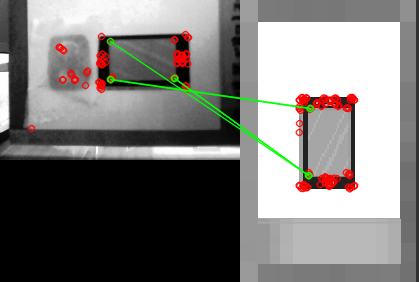

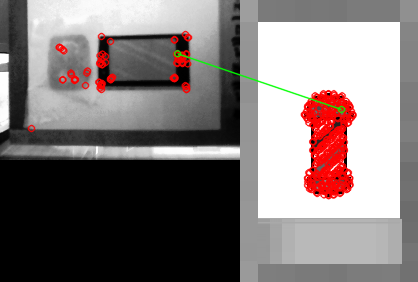

(11, 2)

In [157]:
# 템플릿 이미지 불러오기
frame = camera.capture()
frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
# histogram equalization
frame = cv2.equalizeHist(frame)

# 이미지 keypoint, descriptor 추출
frame_kp, frame_des = orb.detectAndCompute(frame, mask=None)

# 매칭 후 최다 매칭된 Location 인덱스 반환
index_counts = []
for idx, (kp, des) in enumerate(location_kp_des):
    index_counts.append((match(frame_des, des), idx))
    matchDraw(frame, locations[idx], frame_kp, kp, frame_des, des)
max(index_counts)

In [158]:
# 카메라 종료
camera.close()

Closing PiCamera
